In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)

import math
import glob
import io
import base64
from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400,900),)
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
%matplotlib inline

import torch
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import gym

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random

#import frame_player

class A2CNet(nn.Module):
    def __init__(self, in_size, out_size, hidden = 128):
        super(A2CNet, self).__init__()
        self.policy = nn.Sequential(
            nn.Linear(in_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )
        self.value = nn.Sequential(
            nn.Linear(in_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    
    def forward(self, x):
        return self.policy(x), self.value(x)

EPOCH = 2000
BATCH = 5
GAME = "MountainCar-v0"

LR = 0.001
GAMMA = 0.99
ENT_SCALE = 0.1

VIDEO = 50
    
env = gym.make(GAME)
env._max_episode_steps = 1000

net = A2CNet(env.observation_space.shape[0], env.action_space.n)
opt = optim.Adam(net.parameters(), lr=LR)

In [14]:
if __name__ == "__main__":
    batch_cnt = 0
    batch_obs = []
    batch_act = []
    batch_qval = []
    for epoch in range(EPOCH):
        count = 0
        obs = env.reset()
        # if epoch%VIDEO == 0:
        #     env.render()
        cur_rew = []
        while True:
            with torch.no_grad():
                logit, _ = net(torch.FloatTensor(obs))
                act = np.random.choice(env.action_space.n, p=F.softmax(logit).numpy())
                
            next_obs, rew, done, _ = env.step(act)
            # if epoch%VIDEO == 0:
            #     env.render()
            count+=1

            rew = next_obs[0]
            if count!=1000 and done:
              rew = 10
            
            batch_obs.append(obs)
            batch_act.append(act)
            cur_rew.append(rew)
            
            obs = next_obs
            if done:
                qval = []
                r_sum = 0
                for r in reversed(cur_rew):
                    r_sum*= GAMMA
                    r_sum+= r
                    qval.append(r_sum)
                batch_qval.extend(list(reversed(qval)))
                batch_cnt+=1
                break
        print("epoch : %d count : %d rew : %.4f"%(epoch, count, rew))
        if batch_cnt == BATCH:
            obss = torch.FloatTensor(batch_obs)
            acts = torch.LongTensor(batch_act).unsqueeze(1)
            qvals = torch.FloatTensor(batch_qval).unsqueeze(1)
            
            opt.zero_grad()
            
            # use network to get logit, value
            logit, value = net(obss)
            
            # value -> need to be similar to qvals.
            value_loss = F.mse_loss(value, qvals)
            
            # policy gradient. using advatange score to reduce variance.
            log_prob = F.log_softmax(logit, dim=1).gather(1, acts)
            adv = qvals - value.detach()
            policy_value = adv * log_prob
            policy_loss = -policy_value.mean()
            
            # using entropy to make agent explore more.
            prob = F.softmax(logit, dim=1).gather(1, acts)
            entropy = - prob * log_prob 
            entropy_loss = - ENT_SCALE * entropy.mean()
            
            loss = value_loss + policy_loss + entropy_loss
            loss.backward()
            #nn.utils.clip_grad_norm_(net.policy.parameters(), CLIP)
            
            opt.step()
            
            batch_cnt = 0
            batch_obs = []
            batch_act = []
            batch_qval = []
    env.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


epoch : 0 count : 1000 rew : -0.1285
epoch : 1 count : 1000 rew : -0.2862
epoch : 2 count : 1000 rew : -0.5089
epoch : 3 count : 1000 rew : -0.3542
epoch : 4 count : 1000 rew : -0.5598
epoch : 5 count : 1000 rew : -0.4490
epoch : 6 count : 1000 rew : -0.3400
epoch : 7 count : 1000 rew : -0.4732
epoch : 8 count : 1000 rew : -0.6425
epoch : 9 count : 1000 rew : -0.3452
epoch : 10 count : 1000 rew : -0.5307
epoch : 11 count : 1000 rew : -0.3224
epoch : 12 count : 1000 rew : -0.4858
epoch : 13 count : 1000 rew : -0.5647
epoch : 14 count : 1000 rew : -0.4545
epoch : 15 count : 1000 rew : -0.6314
epoch : 16 count : 1000 rew : -0.3879
epoch : 17 count : 1000 rew : -0.4533
epoch : 18 count : 1000 rew : -0.4120
epoch : 19 count : 1000 rew : -0.4615
epoch : 20 count : 1000 rew : -0.3340
epoch : 21 count : 1000 rew : -0.6007
epoch : 22 count : 1000 rew : -0.4133
epoch : 23 count : 1000 rew : -0.4648
epoch : 24 count : 1000 rew : -0.4869
epoch : 25 count : 1000 rew : -0.4895
epoch : 26 count : 100

KeyboardInterrupt: ignored

In [15]:
print(policy_loss, value_loss, entropy_loss)

tensor(-0.0873, grad_fn=<NegBackward>) tensor(66.7762, grad_fn=<MseLossBackward>) tensor(-0.0032, grad_fn=<MulBackward0>)


In [1]:
frame = []
obs = env.reset()
frame.append(env.render(mode="rgb_array"))

while True:
    with torch.no_grad():
        out, _ = net(torch.FloatTensor(obs))
        act = np.random.choice(env.action_space.n, p=F.softmax(out).numpy())

    next_obs, _, done, _ = env.step(act)
    frame.append(env.render(mode="rgb_array"))
    obs = next_obs
    
    if done:
        break
env.close()
len(frame)

NameError: ignored

In [11]:
!pip install JSAnimation
from matplotlib import animation, rc
from JSAnimation.IPython_display import display_animation
from IPython.display import display
from IPython.display import HTML
import os
import glob
import io
import matplotlib.pyplot as plt

# Imports specifically so we can render outputs in Colab.
def display_frames_as_gif(frame, intv=30):
    """Displays a list of frames as a gif, with controls."""
    fig = plt.figure()
    patch = plt.imshow(frame[0].astype(int))
    def animate(i):
        patch.set_data(frame[i].astype(int))
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frame), interval=intv, blit=False
    )
    #display(display_animation(anim, default_mode='loop'))
    # Set up formatting for the movie files
    display(HTML(data=anim.to_html5_video()))
    #FFwriter = animation.FFMpegWriter()
    #anim.save('basic_animation.mp4', writer = FFwriter)
    #show_video()
# display 

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11428 sha256=4286920e57dd1a5227bbc1dfab09248671f1689a523c33bab9ca88e4fa052fd2
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


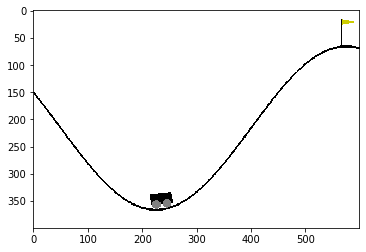

In [12]:
display_frames_as_gif(frame)